In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F #capas sin parametros


In [3]:
class Net(nn.Module):
  def __init__(self, num_channels):
    super(Net,self).__init__()

    self.num_channels = num_channels

    self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride = 1, padding=1)
    self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride = 1, padding=1)
    self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride = 1, padding=1)

    self.fc1 = nn.Linear(self.num_channels*4*8*8, self.num_channels*4)
    self.fc2 = nn.Linear(self.num_channels*4, 6)

  def forward(self,x):
    #Empieza 3x64x64
    x = self.conv1(x) #self.num_channels x 64 x 64
    x = F.relu(F.max_pool2d(x,2)) # num_chanells x 32 x 32
    x = self.conv2(x) #num_chanels*2 x 32 x 32
    x = F.relu(F.max_pool2d(x,2)) # num_chanells x 16 x 16
    x = self.conv3(x) #num_chanels*4 x 16 x 16
    x = F.relu(F.max_pool2d(x,2)) # num_chanels*4  x 8 x 8
    
    #flatten
    x = x.view(-1, self.num_channels*4*8*8)

    #fc
    x = self.fc1(x)
    x = F.relu(x)
    x=self.fc2(x)

    #log_softmax
    x=F.log_softmax(x, dim = 1)

    return x



In [4]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [5]:
!ls '/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS'

test_signs  train_signs  val_signs


In [6]:
import sys
sys.path.append('/gdrive/My Drive/dl-pytorch/')

In [7]:
from plot_helpers import imshow

In [8]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader

class SIGNSDataset(Dataset):
  def __init__(self, base_dir,split="train",transform=None):
    path = os.path.join(base_dir, "{}_signs".format(split))
    files = os.listdir(path)

    self.filenames = [os.path.join(path,f) for f in files if f.endswith(".jpg")]
    self.targets = [int(f[0]) for f in files]
    self.transform = transform
  
  def __len__(self):
    return len(self.filenames)

  def __getitem__(self, idx):
    image = Image.open(self.filenames[idx])
    if self.transform:
      image = self.transform(image)
    return image, self.targets[idx]


In [9]:
signs = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS',split="train")

In [10]:
len(signs)

864

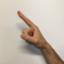

In [11]:
signs[0][0]

In [12]:
import torchvision.transforms as transforms

In [13]:
trainset = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS',split="train", transform = transforms.ToTensor())

In [14]:
dataloader = DataLoader(trainset, batch_size=32)

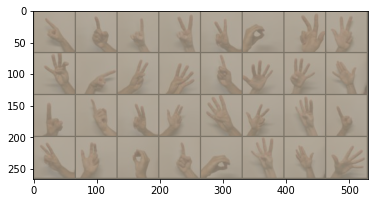

tensor([1, 1, 1, 2, 2, 0, 3, 3, 4, 1, 2, 4, 1, 5, 4, 5, 1, 1, 2, 3, 4, 3, 4, 1,
        2, 3, 0, 1, 0, 4, 5, 5])


In [15]:
from torchvision.utils import make_grid

for inputs, targets in dataloader:
  out = make_grid(inputs)
  imshow(out)
  print(targets)
  break

In [16]:
import torch.optim as optim

In [17]:
device = torch.device('cuda')

In [18]:
device

device(type='cuda')

In [19]:
net = Net(32).to(device)

loss_fn = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

In [20]:
class RunningMetric():
  def __init__(self):
    self.S = 0
    self.N = 0
  def update(self, val, size):
    self.S +=val
    self.N +=size
  def __call__(self):
    return self.S/float(self.N)

In [21]:
num_epochs = 100

In [23]:
for epoch in range(num_epochs):
  print(f'Epoch{epoch+1}/{num_epochs}')
  print('-'*10)

  running_loss = RunningMetric() # perdida
  running_acc = RunningMetric() #precision

  for inputs,targets in dataloader:
    inputs,targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()

    outputs = net(inputs)
    _,preds = torch.max(outputs,1)
    loss = loss_fn(outputs,targets)

    loss.backward() # gradientes calculados automaticamente
    optimizer.step()  #actualiza los parametros

    batch_size = inputs.size()[0]
    running_loss.update(loss.item()*batch_size, batch_size)
    running_acc.update(torch.sum(preds == targets).float(), batch_size)
  print("Loss: {:.4f} Acc: {:.4f}".format(running_loss(),running_acc()))

Epoch1/100
----------
Loss: 1.7930 Acc: 0.1725
Epoch2/100
----------
Loss: 1.7920 Acc: 0.1725
Epoch3/100
----------
Loss: 1.7915 Acc: 0.1725
Epoch4/100
----------
Loss: 1.7909 Acc: 0.1725
Epoch5/100
----------
Loss: 1.7905 Acc: 0.1725
Epoch6/100
----------
Loss: 1.7900 Acc: 0.1725
Epoch7/100
----------
Loss: 1.7895 Acc: 0.1725
Epoch8/100
----------
Loss: 1.7889 Acc: 0.1725
Epoch9/100
----------
Loss: 1.7883 Acc: 0.1771
Epoch10/100
----------
Loss: 1.7877 Acc: 0.1887
Epoch11/100
----------
Loss: 1.7870 Acc: 0.1979
Epoch12/100
----------
Loss: 1.7863 Acc: 0.1968
Epoch13/100
----------
Loss: 1.7854 Acc: 0.2002
Epoch14/100
----------
Loss: 1.7845 Acc: 0.2095
Epoch15/100
----------
Loss: 1.7834 Acc: 0.2130
Epoch16/100
----------
Loss: 1.7822 Acc: 0.2188
Epoch17/100
----------
Loss: 1.7808 Acc: 0.2234
Epoch18/100
----------
Loss: 1.7791 Acc: 0.2419
Epoch19/100
----------
Loss: 1.7770 Acc: 0.2512
Epoch20/100
----------
Loss: 1.7746 Acc: 0.2720
Epoch21/100
----------
Loss: 1.7716 Acc: 0.2824
E